In [208]:
import sys
import rootpath
sys.path.append(rootpath.detect())

In [209]:
import numpy as np
import matplotlib.pyplot as plt

In [210]:
def harrington_df(y, tup1, tup2):
    y1, d1 = tup1
    y2, d2 = tup2
    
    b1 = ((-np.log(-np.log(d2)))+np.log(-np.log(d1)))/(y2-y1)
    b0 = -np.log(-np.log(d1))-b1*y1
    
    return np.exp(-np.exp(-(b0+b1*y)))

In [211]:
def harrington_two_sided(y, n, usl, lsl):
    y_ = (2*y - (usl+lsl))/(usl-lsl)
    return np.exp(-np.abs(y_)**n)

In [212]:
y = np.linspace(0, 60, 100)

In [213]:
tup_01 = (25, 0.99)
tup_02 = (50, 0.01)
d0 = harrington_df(y, tup_01, tup_02)

tup_11 = (20, 0.60)
tup_12 = (35, 0.20)
d1 = harrington_df(y, tup_11, tup_12)

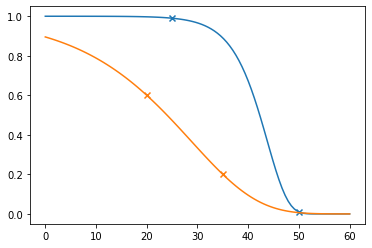

In [214]:
fig = plt.figure()
ax = fig.gca()
ax.plot(y, d0, c="C0")
ax.scatter(*tup_01, marker="x", c="C0")
ax.scatter(*tup_02, marker="x", c="C0")

ax.plot(y, d1, c="C1")
ax.scatter(*tup_11, marker="x", c="C1")
ax.scatter(*tup_12, marker="x", c="C1")

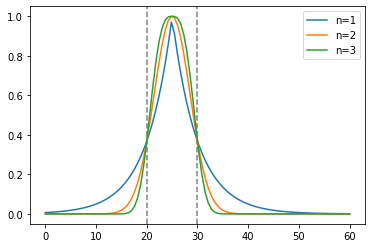

In [215]:
usl = 20
lsl = 30

fig = plt.figure()
ax = fig.gca()
ax.axvline(usl, linestyle="--", c="gray")
ax.axvline(lsl, linestyle="--", c="gray")
for n in [1, 2, 3]:
    d = harrington_two_sided(y, n, usl, lsl)
    ax.plot(y, d, label=f"n={n}")
    
ax.legend()

(0.0, 1.0)

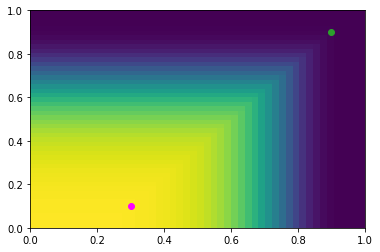

In [262]:
target = np.array([0.3, 0.1]).reshape(1, -1)
ref = np.array([0.9, 0.9]).reshape(1, -1)


tup_01 = (target[0, 0], 0.99)
tup_02 = (ref[0, 0], 0.01)

tup_11 = (target[0, 1], 0.99)
tup_12 = (ref[0, 1], 0.01)

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
xx, yy = np.meshgrid(x, y)
zz = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
df0  = np.array([harrington_df(zi[0], tup_01, tup_02) for zi in zz])
df1  = np.array([harrington_df(zi[1], tup_11, tup_12) for zi in zz])
dgm = (df0*df1)**0.5
dmm = np.array([min(i0, i1) for i0, i1 in zip(df0, df1)])
w = np.array([0.5, 0.9])
dws = (df0*w[0]+df1*w[1])


fig = plt.figure()
ax = fig.gca()
ax.pcolor(xx, yy, dmm.reshape(xx.shape))
ax.scatter(*target.T, c="magenta")
ax.scatter(*ref.T, c="C2")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

(-0.05, 1.05, -0.05, 1.05)

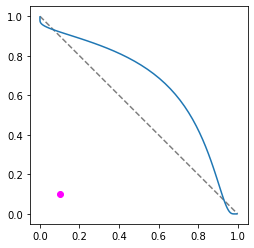

In [266]:
target = np.array([.1, .1])
tup_01 = (target[0], 0.99)
tup_02 = (target[1], 0.99)
tup_11 = (0.75, 0.01)
tup_12 = (0.75, 0.01)

x = np.linspace(0, 1, 100)
y = 1-x

x1 = harrington_df(x, tup_01, tup_11)
y1 = harrington_df(y, tup_02, tup_12)

# x2 = harrington_df(x, tup_01, tup_12)
# y2 = harrington_df(y, tup_01, tup_12)


fig = plt.figure()
ax = fig.gca()
ax.plot(x, y, linestyle="--", c="grey")
ax.plot(x1,y1)
# ax.plot(-x2,-y2)
ax.scatter(*target, c="magenta")
ax.axis("square")

In [221]:
def image_infill(opt, front_value = 0., n_contours=20, uncertainty=0.1):
    #figure_properties
    fig = plt.figure(figsize=[8,7])
    ax = fig.gca()
    l_lims = opt.apply_weighting(np.array([[0, 0]]))
    u_lims = opt.apply_weighting(np.array([[1.5, 1.5]]))
    ax.set_xlim([0., 1.5])
    ax.set_ylim([0., 1.5])
    
    # compute infill
    M, N = 200, 200
    x = np.linspace(0., 1.5, M)
    y = np.linspace(0., 1.5, N)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    xyw = opt.apply_weighting(xy)
    zz = np.array([opt._scalarise_y(xyi, np.ones_like(xyi)*uncertainty*opt.obj_weights, invert=False) for xyi in xyw])
    zz = zz.reshape(N,M)
    
    #image infill
    pcol = ax.pcolor(xx, yy, zz)
    levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
    ax.contour(xx, yy, zz, colors="white", levels=levels)
    if front_value is not None:
        ax.contour(xx, yy, zz, colors="C3", levels=[front_value])
        front_legend = plt.Line2D([0], [0], c="C3")
    
    # scatter samples
    ax.scatter(opt.d[:,0], opt.d[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
    ax.scatter(opt.p[:,0], opt.p[:,1], c="C3", label="non-dominated samples")
    fig.colorbar(pcol)
    handles, labels = ax.get_legend_handles_labels()
    if front_value is not None:
        handles.append(front_legend)
        labels.append("{}".format(front_value))
    ax.legend(handles, labels)
    
    return fig

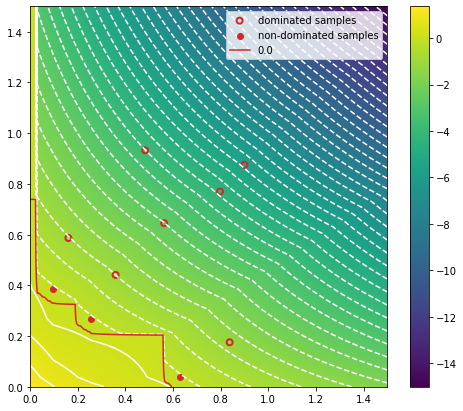

In [226]:
from testsuite.optimisers import SmsEgo
from testsuite.surrogates import GP

smsego_opt = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=GP, n_initial=10, seed=1)
fig_smsego = image_infill(smsego_opt, n_contours=40)

 /tmp/ipykernel_75920/418229984.py:25: UserWarning:No contour levels were found within the data range.


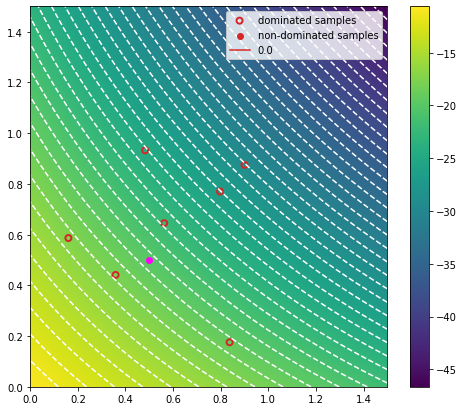

In [243]:
target = np.array([0.09, 0.30]).reshape(1, -1)
ref = np.array([1.4, 1.4]).reshape(1, -1)
tup_01 = (target[0, 0], 0.99)
tup_02 = (ref[0, 0], 0.99)
tup_11 = (target[0, 1], 0.99)
tup_12 = (ref[0, 1], 0.99)

smsego_t = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=GP, n_initial=10, seed=1)
smsego_t.y[:, 0] = -harrington_df(smsego_t.y[:, 0], tup_01, tup_02)
smsego_t.y[:, 1] = -harrington_df(smsego_t.y[:, 1], tup_11, tup_12)

smsego_t.p[:, 0] = -harrington_df(smsego_t.p[:, 0], tup_01, tup_02)
smsego_t.p[:, 1] = -harrington_df(smsego_t.p[:, 1], tup_11, tup_12)


fig_smsego_t = image_infill(smsego_t, n_contours=40)
ax = fig_smsego_t.gca()
ax.scatter(*target.T, c="magenta")

In [234]:
smsego_t.y.shape

(10, 2)